# Singapore Pools Winning Statistics Analysis

This notebook consists of 2 parts: 

1) 4D Analysis 

2) Toto Analysis

In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import requests
import bs4
from bs4 import BeautifulSoup

from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

In [125]:
### Configs / Constants ###
FD_DRAW_LIST_URL = 'http://www.singaporepools.com.sg/DataFileArchive/Lottery/Output/fourd_result_draw_list_en.html'
FD_RESULT_URL = 'http://www.singaporepools.com.sg/en/product/Pages/4d_results.aspx?sppl='
TOTO_DRAW_LIST_URL = 'http://www.singaporepools.com.sg/DataFileArchive/Lottery/Output/toto_result_draw_list_en.html'
TOTO_RESULT_URL = 'http://www.singaporepools.com.sg/en/product/sr/Pages/toto_results.aspx?sppl='

PARSER_NAME = 'html.parser'

SPPL_ATTR = 'querystring'
SPPL_TAG = 'option'

DT_FORMAT = '%d %b %Y'
DRAW_DATE_CLASS = 'drawDate'

FD_FIRST_PRIZE_CLASS = 'tdFirstPrize'
FD_SECOND_PRIZE_CLASS = 'tdSecondPrize'
FD_THIRD_PRIZE_CLASS = 'tdThirdPrize'
FD_STARTER_PRIZE_CLASS = 'tbodyStarterPrizes'
FD_CONSOLATION_PRIZE_CLASS = 'tbodyConsolationPrizes'

FD_STARTER_PRIZE_CSS_SEL = ' '.join(['.' + FD_STARTER_PRIZE_CLASS, 'td'])
FD_CONSOLAION_PRIZE_CSS_SEL = ' '.join(['.' + FD_CONSOLATION_PRIZE_CLASS, 'td'])

TOTO_WIN_CLASS = 'win'
TOTO_ADDITIONAL_CLASS = 'additional'

TOTO_WIN_CSS_SEL = TOTO_WIN_CLASS
TOTO_ADDITIONAL_CSS_SEL = '.' + TOTO_ADDITIONAL_CLASS

FD_LAST_N_DRAWS = 10
TOTO_LAST_N_DRAWS = 20

TOTO_OUTLETS = 'divWinningOutlets'

LOSE = 'Lose'

# Part I: 4D Analysis

In [4]:
### Get 4D Draw List ###
fd_draw_list_page = requests.get(FD_DRAW_LIST_URL)
fd_draw_list_soup = BeautifulSoup(fd_draw_list_page.content, PARSER_NAME)
fd_sppl_ids = [draw.get(SPPL_ATTR).rpartition('=')[2] for draw in fd_draw_list_soup.find_all(SPPL_TAG)]


### Iterate through 4D Draw List to Consolidate 4D Results ###
fd_result_list = []
i = 0
for fd_sppl_id in fd_sppl_ids:
    i += 1
    if i > FD_LAST_N_DRAWS:
        break

    fd_result_page = requests.get(FD_RESULT_URL + fd_sppl_id)
    fd_result_soup = BeautifulSoup(fd_result_page.content, PARSER_NAME)
    
    fd_result_dt = datetime.strptime(
        fd_result_soup.find_all(
            class_=DRAW_DATE_CLASS
        )[0].get_text().rpartition(', ')[2], 
        DT_FORMAT
    )
    fd_result_first_prize = fd_result_soup.find_all(class_=FD_FIRST_PRIZE_CLASS)[0].get_text()
    fd_result_second_prize = fd_result_soup.find_all(class_=FD_SECOND_PRIZE_CLASS)[0].get_text()
    fd_result_third_prize = fd_result_soup.find_all(class_=FD_THIRD_PRIZE_CLASS)[0].get_text()
    fd_result_starter_prize_list = [
        fd_prize_num.get_text() 
        for fd_prize_num 
        in fd_result_soup.select(FD_STARTER_PRIZE_CSS_SEL)
    ]
    fd_result_consolation_prize_list = [
        fd_prize_num.get_text() 
        for fd_prize_num 
        in fd_result_soup.select(FD_CONSOLAION_PRIZE_CSS_SEL)
    ]
    fd_result_round_prize_list = fd_result_consolation_prize_list \
                        + fd_result_starter_prize_list \
                        + [fd_result_first_prize, fd_result_second_prize, fd_result_third_prize]
    
    fd_result_list.append([fd_result_dt, fd_result_first_prize, FD_FIRST_PRIZE_CLASS])
    fd_result_list.append([fd_result_dt, fd_result_second_prize, FD_SECOND_PRIZE_CLASS])
    fd_result_list.append([fd_result_dt, fd_result_third_prize, FD_THIRD_PRIZE_CLASS])
    for fd_prize_num in fd_result_starter_prize_list:
        fd_result_list.append([fd_result_dt, fd_prize_num, FD_STARTER_PRIZE_CLASS])
    for fd_prize_num in fd_result_consolation_prize_list:
        fd_result_list.append([fd_result_dt, fd_prize_num, FD_CONSOLATION_PRIZE_CLASS])
        
    fd_result_round_lose_numbers = [
        [fd_result_dt, str(num).zfill(4), LOSE] 
        for num in range(10000) 
        if str(num).zfill(4) not in fd_result_round_prize_list
    ]
    for fd_lose_set in fd_result_round_lose_numbers:
        fd_result_list.append(fd_lose_set)
        

### Present Findings in pd DataFrame ###
fd_result_df = pd.DataFrame(np.array(fd_result_list), columns=['Date', 'Prize Number', 'Prize Type'])
fd_result_df.set_index('Date', inplace=True)
fd_result_df['Win'] = (fd_result_df['Prize Type'] != LOSE).replace(True, 1)

### Get individual digits of winning number + some feature engineering ###
fd_position_set = ('First', 'Second', 'Third', 'Fourth')
fd_number_set = ('Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine')

#### Feature for numbers in each digit position ####
for i, position in enumerate(fd_position_set):
    column_name = position + ' Digit'
    fd_result_df[column_name] = fd_result_df['Prize Number'].str[i]

#### One hot features for each position + number combination ####
for i, position in enumerate(fd_position_set):
    for j, number in enumerate(fd_number_set):
        column_name = position + ' Digit ' + number
        fd_result_df[column_name] = (fd_result_df['Prize Number'].str[i] == str(j)).replace(True, 1)

#### One hot features for number ####
for k, number in enumerate(fd_number_set):
    column_name = 'Has ' + number
    fd_result_df[column_name] = fd_result_df['Prize Number'].str.contains(str(k)).replace(True, 1)


In [5]:
### Data Analysis for visualization ###
prize_num_freq = fd_result_df[fd_result_df['Prize Type'] != LOSE].groupby(['Prize Number']).count().iloc[:, 0].sort_values(ascending=False)
first_digit_freq = fd_result_df[fd_result_df['Prize Type'] != LOSE].groupby('First Digit').count().iloc[:, 0]
second_digit_freq = fd_result_df[fd_result_df['Prize Type'] != LOSE].groupby('Second Digit').count().iloc[:, 0]
third_digit_freq = fd_result_df[fd_result_df['Prize Type'] != LOSE].groupby('Third Digit').count().iloc[:, 0]
fourth_digit_freq = fd_result_df[fd_result_df['Prize Type'] != LOSE].groupby('Fourth Digit').count().iloc[:, 0]
digit_freq = fd_result_df[fd_result_df['Prize Type'] != LOSE].iloc[:, -10:].sum()

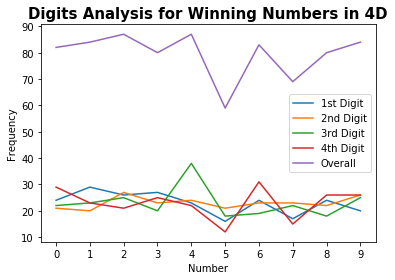

In [10]:
### Analysis of Digits ###
plt.plot(first_digit_freq, label='1st Digit')
plt.plot(second_digit_freq, label='2nd Digit')
plt.plot(third_digit_freq, label='3rd Digit')
plt.plot(fourth_digit_freq, label='4th Digit')
plt.plot([i for i in range(10)], digit_freq, label='Overall')
plt.title('Digits Analysis for Winning Numbers in 4D', fontdict={'fontsize':15, 'fontweight':'bold'})
plt.xlabel('Number')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Some findings from the above plot:
* Number "1" occurs quite frequently as the 1st digit
* Occurences of all numbers in the 2nd digit appears to be quite balanced
* Number "4" occurs quite frequently as the 3rd digit
* Number "6" occurs quite frequently as the 4th digit
* Number "5" occurs the least frequently

## Attempt to use Light GBM as an estimator
* Use of GridSearch to optimize estimator's parameters
* Use scoring='average_precision' to pick model that has higher rates of picking true positives out of all positives
  * After all for winning numbers that we cannot predict (i.e. False Negatives), the cost of missing them (i.e. cost of lower recall) is lower than the cost of not being able to pick the correct winning numbers (i.e. cost of precision)

In [11]:
### Read Data ###
X_train = fd_result_df.iloc[:, 7:]
Y_train = fd_result_df.iloc[:, 2]

### GridSearchCV on LightGBM Params ###
lgbmc = LGBMClassifier()
param_grid = [
    {
        'n_jobs': [2],
        'n_estimators': [3, 5, 10],
        'max_depth': [2],
        'reg_lambda': [0]
    }
]

start_time = datetime.now()
gscv = GridSearchCV(estimator=lgbmc, n_jobs=2, cv=5, param_grid=param_grid, scoring='average_precision')
gscv.fit(X_train, Y_train)
end_time = datetime.now()
print('Time taken for Grid Search: ', end_time - start_time)
print('Best score for lgbmc: ', gscv.best_score_)
print('Best params for lgbmc: ', gscv.best_params_)

### Set best estimator from GridSearchCV ###
lgbmc = gscv.best_estimator_

Time taken for Grid Search:  0:00:08.062435
Best score for lgbmc:  0.0029600191390077657
Best params for lgbmc:  {'max_depth': 2, 'n_estimators': 10, 'n_jobs': 2, 'reg_lambda': 0}


In [12]:
### Preparing Test Data ###
X_test = pd.DataFrame(np.array([str(num).zfill(4) for num in range(10000)]), columns=['Prize Number'])

#### One hot features for each position + number combination ####
for i, position in enumerate(fd_position_set):
    for j, number in enumerate(fd_number_set):
        column_name = position + ' Digit ' + number
        X_test[column_name] = (X_test['Prize Number'].str[i] == str(j)).replace(True, 1)

#### One hot features for number ####
for k, number in enumerate(fd_number_set):
    column_name = 'Has ' + number
    X_test[column_name] = X_test['Prize Number'].str.contains(str(k)).replace(True, 1)

    
### Predicting 'Best' 4D Number ###
Y_pred = pd.DataFrame(lgbmc.predict_proba(X_test.iloc[:, 1:]), columns=['Lose', 'Win'])
XY_pred_join = pd.concat([X_test.loc[:, 'Prize Number'], Y_pred.loc[:, 'Win']], axis=1)
print('Predicting top 10 4D winning numbers: ')
XY_pred_join.sort_values('Win', ascending=False).head(10).style

Predicting top 10 4D winning numbers: 


,Prize Number,Win
1243,1243,0.00514553
1043,1043,0.00514553
1843,1843,0.00514553
1643,1643,0.00514553
1443,1443,0.00514553
1343,1343,0.00514553
1143,1143,0.00514553
1743,1743,0.00514553
1943,1943,0.00514553
1644,1644,0.00425899


<i style="color: green">^^My 4D prediction above (take it with a pinch of salt, only 0.5% confident :P)</i>

## <i> Activity for 4D Analysis </i>
### Try to replace the number below in '<i style="color: blue">fd_user_number</i>' variable, and execute the below block to get the probability of winning!

In [38]:
fd_user_number = '1204'

In [39]:
### Prep data for feature engineering before prediction ###
fd_user_number_df = pd.DataFrame(np.array([fd_user_number]), columns=['Prize Number'])

#### One hot features for each position + number combination ####
for i, position in enumerate(fd_position_set):
    for j, number in enumerate(fd_number_set):
        column_name = position + ' Digit ' + number
        fd_user_number_df[column_name] = (fd_user_number_df['Prize Number'].str[i] == str(j)).replace(True, 1).replace(False, 0)

#### One hot features for number ####
for k, number in enumerate(fd_number_set):
    column_name = 'Has ' + number
    fd_user_number_df[column_name] = fd_user_number_df['Prize Number'].str.contains(str(k)).replace(True, 1).replace(False, 0)
    
print('Your probability of winning for number {}: {}%'.format(
    fd_user_number,
    lgbmc.predict_proba(fd_user_number_df.iloc[:, 1:])[:, 1][0] * 100)
     )

Your probability of winning for number 1204: 0.237575064857751%


# Part II: Toto Numbers Analysis

In [151]:
### Get Toto Draw List ###
toto_draw_list_page = requests.get(TOTO_DRAW_LIST_URL)
toto_draw_list_soup = BeautifulSoup(toto_draw_list_page.content, PARSER_NAME)
toto_sppl_ids = [draw.get(SPPL_ATTR).rpartition('=')[2] for draw in toto_draw_list_soup.find_all(SPPL_TAG)]

### Iterate through draw list and consolidate results ###
toto_result_list = []
i = 0
for toto_sppl_id in toto_sppl_ids:
    i += 1
    if i > TOTO_LAST_N_DRAWS:
        break
    toto_result_page = requests.get(TOTO_RESULT_URL + toto_sppl_id)
    toto_result_soup = BeautifulSoup(toto_result_page.content, PARSER_NAME)
    toto_result_dt = datetime.strptime(
        toto_result_soup.find_all(class_=DRAW_DATE_CLASS)[0].get_text().rpartition(', ')[2], 
        DT_FORMAT
    )
    toto_prize_numbers = [
        int(toto_prize_num.get_text())
        for toto_prize_num 
        in toto_result_soup.find_all('td', {'class': lambda x: x and x.startswith(TOTO_WIN_CSS_SEL)})
    ]
    toto_additional_number = int(toto_result_soup.select(TOTO_ADDITIONAL_CSS_SEL)[0].get_text())
    toto_lose_numbers = [
        toto_lose_number for toto_lose_number in range(1, 50) 
        if toto_lose_number not in toto_prize_numbers
        and toto_lose_number != toto_additional_number
    ]
    
    toto_result_list.append([toto_result_dt, toto_additional_number, TOTO_ADDITIONAL_CLASS])
    for toto_prize_num in toto_prize_numbers:
        toto_result_list.append([toto_result_dt, toto_prize_num, TOTO_WIN_CLASS])
    for toto_lose_num in toto_lose_numbers:
        toto_result_list.append([toto_result_dt, toto_lose_num, LOSE])
    
    ### Check for G1 Winners ###
    has_g1_winners = len(toto_result_soup.select('.divWinningOutlets > div + p + ul')) != 0
    ### Check for G2 Winners ###
    has_g2_winners = len(toto_result_soup.select('.divWinningOutlets > div + p ~ p + ul')) != 0
    
    
### Present Findings in pd DataFrame ###
toto_result_df = pd.DataFrame(np.array(toto_result_list), columns=['Date', 'Win Number', 'Win Type'])
toto_result_df.set_index('Date', inplace=True)
toto_result_df['Win'] = (toto_result_df['Win Type'] != LOSE).replace(True, 1)

In [163]:
### Sample of toto result dataframe ###
toto_result_df.head()

,Win Number,Win Type,Win
Date,,,
2019-08-19,30,additional,1.0
2019-08-19,2,win,1.0
2019-08-19,6,win,1.0
2019-08-19,19,win,1.0
2019-08-19,20,win,1.0


In [162]:
print('Winning Number Frequencies')
pd.DataFrame(
    toto_result_df[toto_result_df['Win'] == 1].groupby('Win Number').count().iloc[:, 0].sort_values(ascending=False)
).head().style

Winning Number Frequencies


,Win Type
Win Number,
4,6
30,6
34,5
29,5
36,5


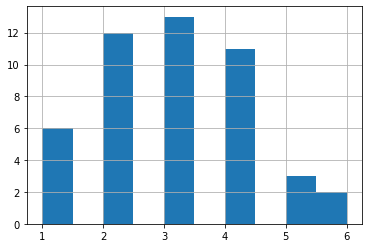

In [150]:
### Plot out histogram of number occurences frequencies ###
toto_result_df[toto_result_df['Win'] == 1].groupby('Win Number').count().iloc[:, 0].sort_values(ascending=False).hist()